In [2]:
# setup
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# setup: has to be in a separate cell for some reason
plt.rcParams['figure.figsize'] = [15, 6]

In [32]:
def run_sim(N0, M0, gen_fn, ngens, dtype='int', **kwargs):
    assert(len(N0) == len(M0))
    N = np.empty((ngens, len(N0)), dtype=dtype)
    N[0, :] = N0
    M = np.empty((ngens, len(M0)), dtype=dtype)
    M[0, :] = M0
    for t in range(1, ngens):
        N[t, :], M[t, :] = gen_fn(N[t-1, :], M[t-1, :], **kwargs)
    return N, M

def phase_plot(genfn, xlim, ylim, nx, ny, **kwargs):
    xstep = int((xlim[1] - xlim[0]) / nx)
    ystep = int((ylim[1] - ylim[0]) / ny)
    X, Y = np.meshgrid(range(xlim[0], xlim[1], xstep), range(ylim[0], ylim[1], ystep))
    X.shape = Y.shape = (np.prod(X.shape),)
    U, V = genfn(X, Y, **kwargs)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.quiver(X, Y, U-X, V-Y, angles='xy', scale_units='xy', scale=1)
    return plt

# More than one species?

Let's get some species *interactions* happening!
Suppose that a *prey* species follows the dynamics above,
except that *also*,
5. Each prey is eaten by a predator, with probability $a$ per predator,
    and turned into a Poisson($b$) number of new predators.
6. Each predator dies with probability $q$.

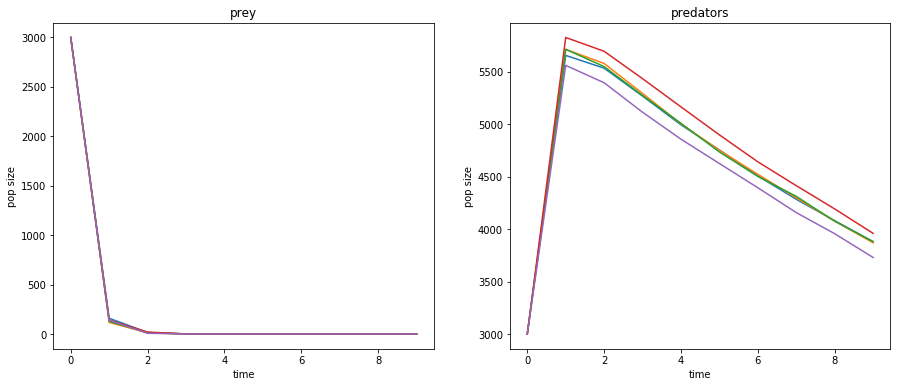

In [18]:
def pred_prey_gen(N, M, lam, p, a, K, b, q):
    assert(len(M) == len(N))
    num_eat =  np.random.binomial(N, 1 - np.power(1 - a, M), len(N))
    next_N = (np.random.poisson(lam * N * np.fmax(0.0, 1 - N / K), len(N)) 
              + np.random.binomial(N - num_eat, p, len(N)))
    next_M = (np.random.binomial(M, q, len(M))
              + np.random.poisson(b * num_eat, len(M)))
    return next_N, next_M

# run five simulations
N = np.empty((10, 5), dtype='int')
M = np.empty(N.shape, dtype='int')
N[0, :] = 3000
M[0, :] = 3000
for t in range(1, len(N)):
    N[t, :], M[t, :] = pred_prey_gen(N[t-1, :], M[t-1, :], lam=0.1, p=0.95, K=2000,
                            a=0.001, b=1, q=0.95)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.plot(N)
ax.set_title('prey')
ax.set_xlabel("time")
ax.set_ylabel("pop size")
ax = fig.add_subplot(122)
ax.set_title('predators')
ax.plot(M, label='logistic growth')
ax.set_xlabel("time")
ax.set_ylabel("pop size")
plt.show()

# Phase plots, predator-prey

Equilibrium =  (999.9999999999998, -4454.545454545454) 
r =  1.0899999999999999


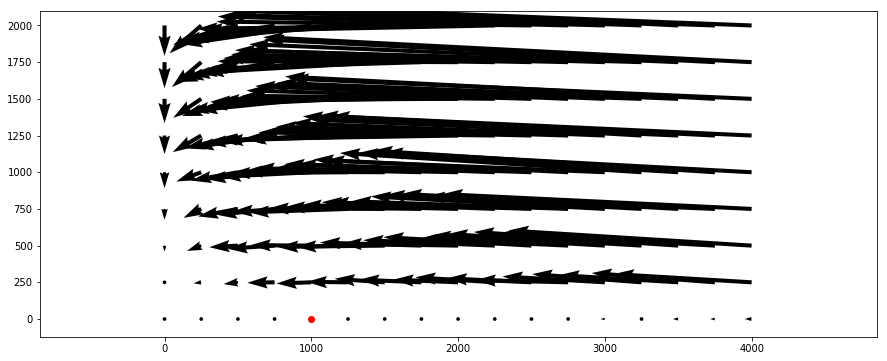

In [69]:
def pred_prey_gen(N, M, lam, p, a, K, b, q):
    assert(len(M) == len(N))
    num_eat =  np.random.binomial(N, 1 - np.power(1 - a, M), len(N))
    next_N = (np.random.poisson(lam * N * np.fmax(0.0, 1 - N / K), len(N)) 
              + np.random.binomial(N - num_eat, p, len(N)))
    next_M = (np.random.binomial(M, q, len(M))
              + np.random.poisson(b * num_eat, len(M)))
    return next_N, next_M

lam = 1.1 # prey fecundity per year
p = 0.99  # prey survival prob
K = 200   # prey carrying capacity
a = 0.001 # pred-prey encounter rate
b = 0.1   # prey->pred conversion rate
q = 0.9  # pred survival prob
equil = ((1-q)/(a*b), (p + lam - 1 - (1-q) * lam / (a*b*K))/(a*p))
print("Equilibrium = ", equil, "\nr = ", p + lam - 1)
X, Y = np.meshgrid(range(0, 4001, 250), range(0, 2001, 250))
X.shape = Y.shape = (np.prod(X.shape),)
U, V = pred_prey_gen(X, Y, lam=lam, p=p, K=K, a=a, b=b, q=q)


fig = plt.figure()
ax = fig.add_subplot(111)
plt.axis('equal')
ax.quiver(X, Y, U-X, V-Y, angles='xy', scale_units='xy', scale=1)
ax.scatter(max(0.0, equil[0]), max(0.0, equil[1]), color='r')
plt.show()

# Susceptible-Infected

The parameters are:

- `theta` : birth rate of new individuals
- `c` : per capita encounter rate
- `a` : transmission rate per encounter
- `rho` : recovery rate
- `d` : death rate of susceptible individuals
- `delta` : death rate of infected individuals

The equation is
$$\begin{aligned}
  \frac{dN}{dt} &= \theta - d N - a c N M + \rho M \\
  \frac{dN}{dt} &= a * c * N * M - \delta M - \rho M  
\end{aligned}$$



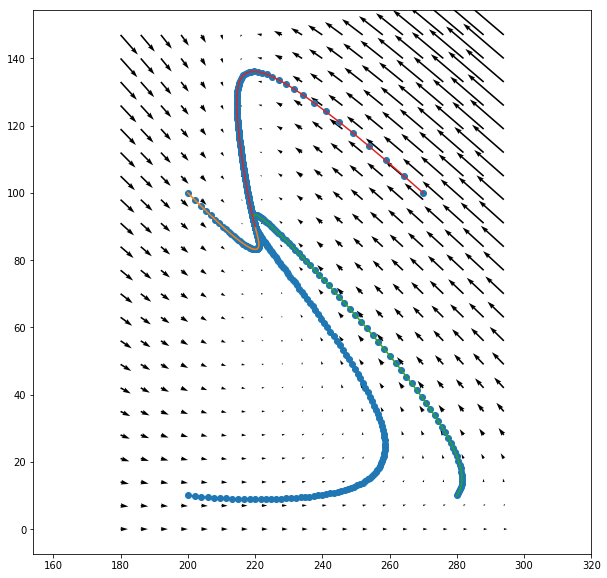

In [44]:
def SI_eqn(N, M, r, theta, c, a, rho, d, delta):
    next_N = N +  r * (theta - d * N - a * c * N * M + rho * M)
    next_M = M + r * (a * c * N * M - delta * M - rho * M)
    return next_N, next_M

SI_args = {'r' : 1.0, 'theta' : 4, 'c' : 0.01, 'a' : 0.1, 'rho' : 0.2, 'd' : 0.01, 'delta' : 0.02}

N, M = run_sim([200, 200, 280, 270], [10, 100, 10, 100], SI_eqn, 1000, dtype='float',
               **SI_args)

plt.rcParams['figure.figsize'] = [10, 10]
plt = phase_plot(SI_eqn, xlim=[180, 300], ylim=[0, 150], nx=20, ny=20,
                 **SI_args)
ax = plt.gca()
ax.plot(N, M)
ax.scatter(N, M)
plt.axis('equal')
plt.show()

So, suppose that in a time step of length $r$,

1. some fraction of susceptibles and infecteds die, with probabilities $rd$ and $r\delta$ respectively,
2. some fraction of infecteds recover, with probability $r \rho$,
3. each susceptible, encounters a Binomial($M$, $rc$) number of infecteds,
    each of which has a chance $a$ of infecting them, and
4. a new Poisson($r \theta$) number of susceptibles show up.

Note that the probability a given susceptible will be infected by a given infected individual is $r c a$,
and so the probability that a susceptible will be infected is
$$
  1 - (1-rca)^M  \approx r c a M .
$$

In this model,
$$\begin{aligned}
  \mathbb{E}[N_{t+1}|N_t = N, M_t = M]
      &= r \theta + (1 - rca)^M (1-rd) N + r \rho M \\
      &\approx N + r \left\{ \theta - d N - ca MN + \rho M \right\} \\
  \mathbb{E}[M_{t+1}|N_t = N, M_t = M]
      &= (1 - (1 - rca)^M) (1-rd) N + (1-r\delta) M \\
      &\approx M + r \left\{ ca M N - \delta M \right\} .
\end{aligned}$$

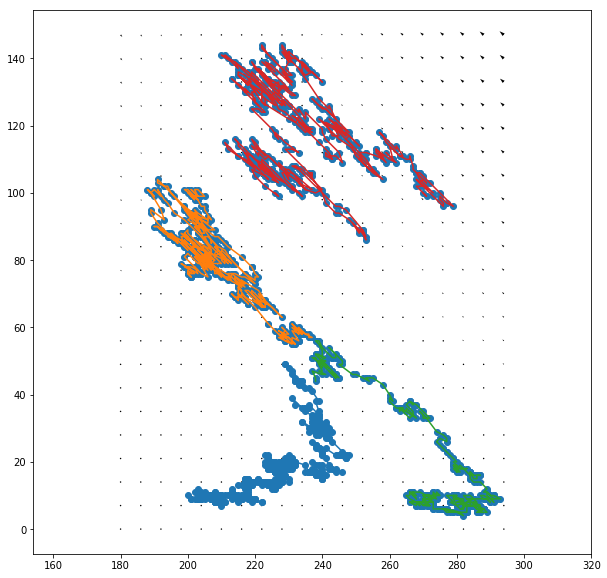

In [94]:
def SI_gen(N, M, r, theta, c, a, rho, d, delta):
    assert(len(M) == len(N))
    s_deaths = np.random.binomial(N, r * d)
    i_deaths = np.random.binomial(M, r * delta)
    infections = np.random.binomial(N - s_deaths, 1 - np.power(1 - r * a * c, M))
    recoveries = np.random.binomial(M - i_deaths, r * rho)
    births = np.random.poisson(r * theta)
    next_N = N - s_deaths - infections + recoveries + births
    next_M = M - i_deaths + infections - recoveries
    return next_N, next_M

SI_args = {'r' : 0.1, 'theta' : 4, 'c' : 0.01, 'a' : 0.1, 'rho' : 0.2, 'd' : 0.01, 'delta' : 0.02}
N, M = run_sim([200, 200, 270, 270], [10, 100, 10, 100], SI_gen, 500, dtype='int',
               **SI_args)

plt.rcParams['figure.figsize'] = [10, 10]
plt = phase_plot(SI_eqn, xlim=[180, 300], ylim=[0, 150], nx=20, ny=20,
                 **SI_args)
ax = plt.gca()
ax.plot(N, M)
ax.scatter(N, M)
plt.axis('equal')
plt.show()

**Exercise:** Sometimes the infection dies out.
Modify the model so that new infections can occur from some other source.

# Competition

The Lotka-Volterra competition equations are
$$\begin{aligned}
  \frac{dN}{dt}
      &= r_0 N \left( 1 - \frac{N + a_0 M}{K_0} \right) \\
  \frac{dM}{dt}
      &= r_1 M \left( 1 - \frac{M + a_1 N}{K_1} \right) 
\end{aligned}$$

A model is as follows:

1. Each time step, each type-0 individual has probability $r p_0$ of dying,
   and producing a Poisson number of offspring.
2. The mean number of offspring depends on the current amount of resources:
   it is equal to $\lambda_0 \exp(- (N + a_0 M)/C_0)$, for some $a_0 < 1$,
   because each type-1 individual competes somewhat (but, less) than with a type-0.
3. Same, vice-versa.

This has
$$\begin{aligned}
  \mathbb{E}[N_{t+1} | N_t = N, M_t = M]
      &= N (1 - r p_0) + r p_0 N \lambda_0 \exp(- (N + a_0 M)/C_0) \\
      &\approx N + r p_0 N \left( \lambda_0 - 1 - \lambda_0 \frac{N + a_0 M}{C_0} \right) \\
      &= N + r p_0 (\lambda_0 - 1) N \left( 1 - \frac{N + a_0 M}{C_0 (\lambda_0 - 1)/\lambda_0} \right) .
\end{aligned}$$

Note that $\mathbb{E}[N_{t+1} | N_t = N, M_t = M] = N$ if $(N + a_0 M)/C_0 = \log \lambda_0$,
so the equilibrium occurs when
$$\begin{aligned}
  N + a_0 M &= C_0 \log(\lambda_0) \\
  a_1 N + M &= C_1 \log(\lambda_1)  
\end{aligned}$$
which is solved by
$$\begin{aligned}
  N &= \frac{C_0 \log(\lambda_0) - a_0 C_1 \log(\lambda_1)}{1 - a_0 a_1} \\
  M &= \frac{C_1 \log(\lambda_1) - a_1 C_0 \log(\lambda_0)}{1 - a_0 a_1} .
\end{aligned}$$

equilibrium: [329.8172138  348.25899784]


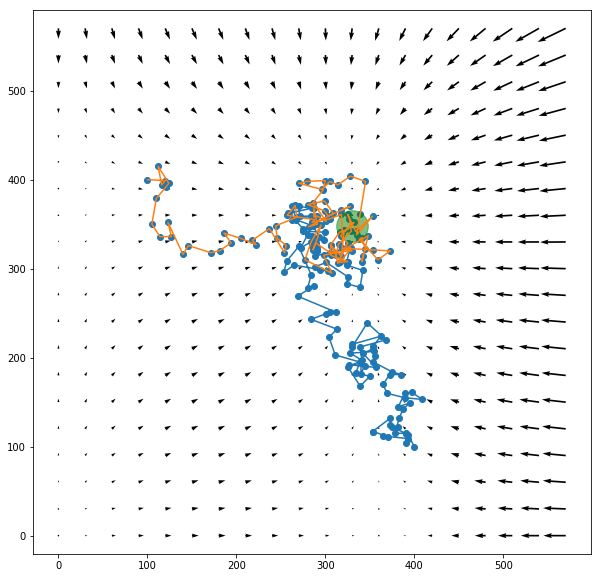

In [170]:
def competition_eqn_approx(N, M, r, lam, p, K, a):
    r = [r * pp * (ll - 1) for ll, pp in zip(lam, p)]
    next_N = N + r[0] * N * (1 - (N + a[0] * M)/(K[0] * (lam[0] - 1)/lam[0]))
    next_M = M + r[1] * M * (1 - (M + a[1] * N)/(K[1] * (lam[1] - 1)/lam[1]))
    return next_N, next_M

def competition_eqn(N, M, r, lam, p, K, a):
    next_N = N + r * p[0] * N * (lam[0] * np.exp(-(N + a[0] * M)/K[0]) - 1)
    next_M = M + r * p[1] * M * (lam[1] * np.exp(-(M + a[1] * N)/K[1]) - 1)
    return next_N, next_M

def competition_gen(N, M, r, lam, p, K, a):
    assert(len(M) == len(N))
    N_dies = np.random.binomial(N, 1 - r * p[0])
    N_repro = np.random.poisson(N_dies * lam[0] * np.exp(-((N + a[0]*M)/K[0])))
    next_N = N - N_dies + N_repro
    M_dies = np.random.binomial(M, 1 - r * p[1])
    M_repro = np.random.poisson(M_dies * lam[1] * np.exp(-((M + a[1]*M)/K[1])))
    next_M = M - M_dies + M_repro
    return next_N, next_M

def competition_equil(r, lam, p, K, a):
    return np.array([K[0] * np.log(lam[0]) - a[0] * K[1] * np.log(lam[1]),
                     K[1] * np.log(lam[1]) - a[1] * K[0] * np.log(lam[0])]) / (1 - a[0] * a[1])

competition_args = {
        'r' : 0.9,            # overall time scaling
        'lam' : [1.2, 1.1],    # fecundity
        'p' : [0.5, 0.5],      # survival prob
        'K' : [2000, 4000],      # carrying capacity
        'a' : [0.1, 0.1]  # encounter rate
    }
equil = competition_equil(**competition_args)
print("equilibrium:", equil)
N, M = run_sim([400, 100], [100, 400], competition_gen, 100, dtype='int',
               **competition_args)

plt = phase_plot(competition_eqn, xlim=[0, 600], ylim=[0, 600], nx=20, ny=20,
                 **competition_args)
ax = plt.gca()
ax.plot(N, M)
ax.scatter(N, M)
ax.scatter(equil[0], equil[1], s=1000, c='g', alpha=0.5)
plt.axis('equal')
plt.show()

## Cooperation?

equilibrium: [170.5196879  275.88020356]


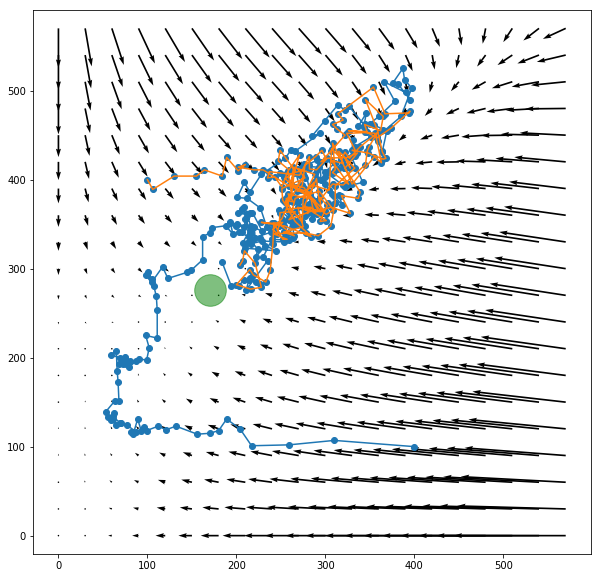

In [179]:
cooperation_args = {
        'r' : 0.9,            # overall time scaling
        'lam' : [0.9, 1.1],    # fecundity
        'p' : [0.5, 0.5],      # survival prob
        'K' : [1000, 2000],      # carrying capacity
        'a' : [-1.0, -0.5]  # encounter rate
    }
equil = competition_equil(**cooperation_args)
print("equilibrium:", equil)
N, M = run_sim([400, 100], [100, 400], competition_gen, 200, dtype='int',
               **cooperation_args)

plt = phase_plot(competition_eqn, xlim=[0, 600], ylim=[0, 600], nx=20, ny=20,
                 **cooperation_args)
ax = plt.gca()
ax.plot(N, M)
ax.scatter(N, M)
ax.scatter(equil[0], equil[1], s=1000, c='g', alpha=0.5)
plt.axis('equal')
plt.show()